In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import camb
import hankl
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=12)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=13)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=13)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, get_xi_from_P

In [16]:
## Cosmological Parameters
param = {}
param['Omegam']  = 0.3099
param['Omegab']  = 0.0488911
param['OmegaDE'] = 1.0-param['Omegam']
param['w_DE_0']  = -0.99
param['w_DE_a']  = 0.0
param['cs2_DE']  = 1.0
param['Omegak']  = 0.0
param['A_s']     = 2.1064e-09
param['n_s']     = 0.96822
param['H0']      = 67.742
param['Tcmb']    = 2.7255
param['YHe']     = 0.248
param['Neff']    = 2.046 # 3.046-1 since massive neutrino present
param['Nmnu']    = 1.0
param['mnu']     = 0.06  #eV
k_p = 0.05
h = param['H0']/100

# modes to sample
nmodes = 256
kmin = 1e-5
kmax = 1e+2
aexp=1.0 #0.01

## Compute Background evolution
param = evolve_background(param=param)

In [5]:
# Compute Perturbations
aexp_out = jnp.array([aexp]) 

y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  rtol=1e-4, atol=1e-4 )


In [6]:
# Compute power spectra from transfer functions
iout = -1
fac = 2 * np.pi**2 * param['A_s']
Pkc = fac *(kmodes/k_p)**(param['n_s'] - 1) * kmodes**(-3) * y[:,iout,3]**2
Pkb = fac *(kmodes/k_p)**(param['n_s'] - 1) * kmodes**(-3) * y[:,iout,5]**2
Pknu = fac *(kmodes/k_p)**(param['n_s'] - 1) * kmodes**(-3) * y[:,iout,7]**2
Pkm = fac *(kmodes/k_p)**(param['n_s'] - 1) * kmodes**(-3) * y[:,iout,9]**2
Pkbc = fac *(kmodes/k_p)**(param['n_s'] - 1) * kmodes**(-3) * y[:,iout,10]**2

In [20]:
xi0, r = get_xi_from_P( kmodes, Pkm, N=nmodes, ell=0 )
xi2, r = get_xi_from_P( kmodes, Pkm, N=nmodes, ell=2 )


/home/ohahn/.local/lib/python3.10/site-packages/jax/_src/array.py:363: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)
/home/ohahn/.local/lib/python3.10/site-packages/jax/_src/array.py:363: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


(20.0, 160.0)

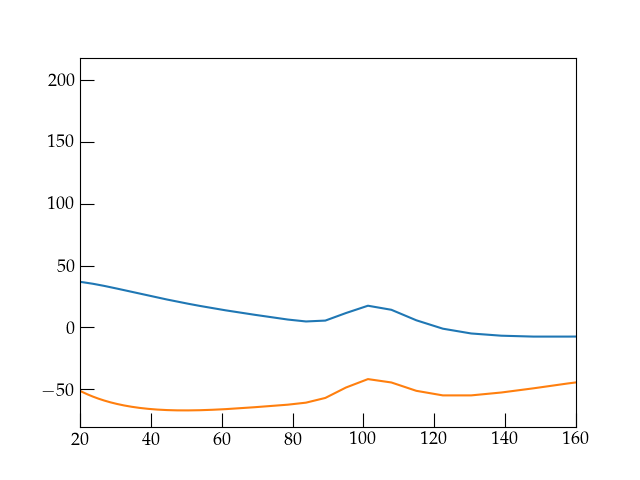

In [22]:
fig, ax = plt.subplots()

ax.plot( r*h, (r*h)**2 *  xi0 )
ax.plot( r*h, (r*h)**2 *  xi2 )
ax.set_xlim(20,160)
